In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from subprocess import check_output
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product
warnings.filterwarnings('ignore')

/var/folders/8t/_xbd4d4117l1s7h5p9tj9rxr0000gn/T/ipykernel_1643/3924545181.py:9: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


In [2]:
cba = pd.read_excel('CBAmax.xls')

In [3]:
cba.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1991-10-01,6.78662,6.78662,6.78662,6.78662,1.290987,0
1,1991-10-02,6.78662,6.78662,6.78662,6.78662,1.290987,0
2,1991-10-03,6.78662,6.78662,6.78662,6.78662,1.290987,0
3,1991-10-04,6.78662,6.78662,6.78662,6.78662,1.290987,0
4,1991-10-07,6.78662,6.78662,6.78662,6.78662,1.290987,0


In [4]:
cba.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
7856,2022-09-29,93.830002,94.190002,93.120003,93.120003,93.120003,2094138
7857,2022-09-30,93.220001,93.230003,90.260002,90.699997,90.699997,3741428
7858,2022-10-03,91.150002,91.370003,89.660004,90.610001,90.610001,2038034
7859,2022-10-04,92.000000,94.870003,91.889999,94.790001,94.790001,3030551
7860,2022-10-05,95.989998,97.599998,95.790001,97.290001,97.290001,3840988


In [5]:
cba.columns = cba.columns.str.lower()

In [6]:
cba['movement'] = cba['close']-cba['open']

In [7]:
cba.head()

,date,open,high,low,close,adj close,volume,movement
0,1991-10-01,6.78662,6.78662,6.78662,6.78662,1.290987,0,0.0
1,1991-10-02,6.78662,6.78662,6.78662,6.78662,1.290987,0,0.0
2,1991-10-03,6.78662,6.78662,6.78662,6.78662,1.290987,0,0.0
3,1991-10-04,6.78662,6.78662,6.78662,6.78662,1.290987,0,0.0
4,1991-10-07,6.78662,6.78662,6.78662,6.78662,1.290987,0,0.0


<Figure size 720x576 with 0 Axes>

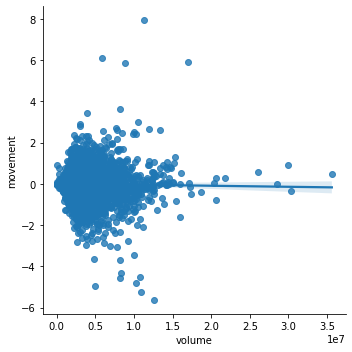

In [8]:
plt.figure(figsize=(10,8))
sns.lmplot(x='volume', y='movement', data=cba);
plt.show()

<AxesSubplot:>

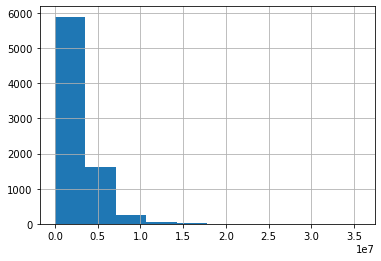

In [9]:
cba['volume'].hist()

<AxesSubplot:>

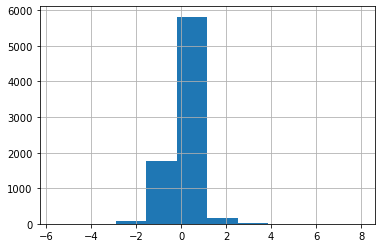

In [10]:
cba['movement'].hist()

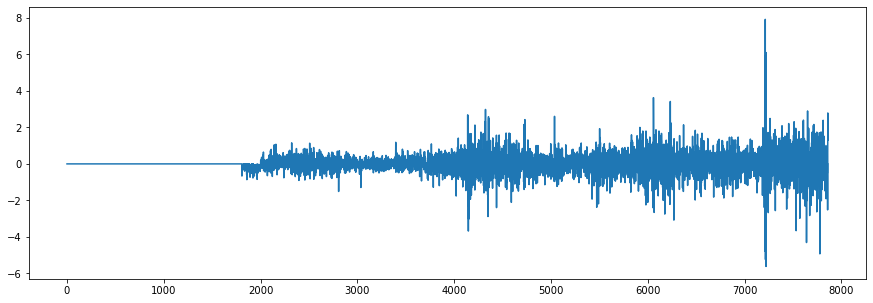

In [11]:
cba['movement'].plot(style='-', figsize=(15, 5))
plt.show()

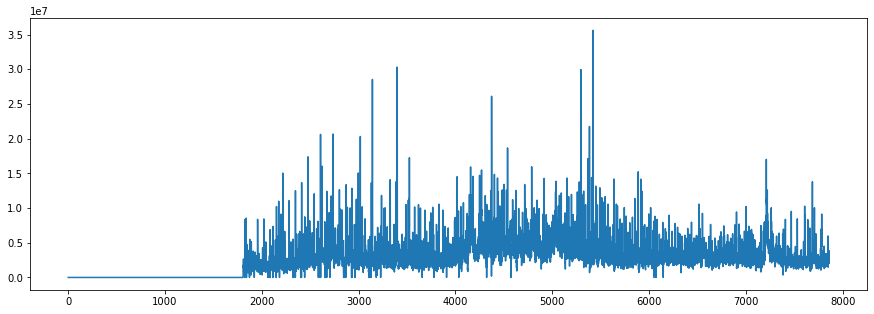

In [12]:
cba['volume'].plot(style='-', figsize=(15, 5))
plt.show()

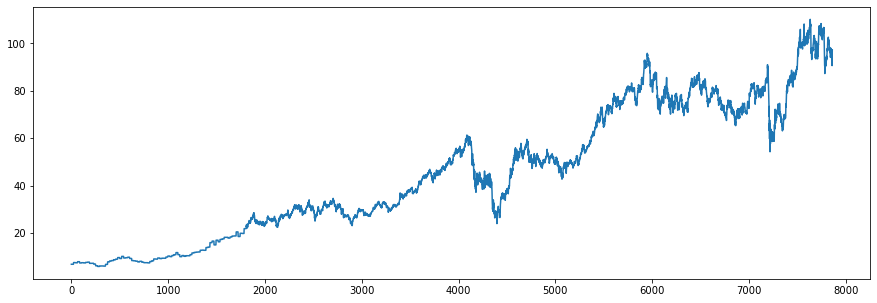

In [13]:
cba['close'].plot(style='-', figsize=(15, 5))
plt.show()

In [14]:
import datetime

def str_to_datetime(s):
  split = s.split('-')
  year, month, day = int(split[0]), int(split[1]), int(split[2])
  return datetime.datetime(year=year, month=month, day=day)

In [15]:
datetime_object = str_to_datetime('2017-09-21')
datetime_object

datetime.datetime(2017, 9, 21, 0, 0)

In [16]:
cba = cba.drop(labels = ['open', 'high', 'low', 'close', 'adj close', 'volume'], axis=1)

In [17]:
cba

,date,movement
0,1991-10-01,0.000000
1,1991-10-02,0.000000
2,1991-10-03,0.000000
3,1991-10-04,0.000000
4,1991-10-07,0.000000
...,...,...
7856,2022-09-29,-0.709999
7857,2022-09-30,-2.520004
7858,2022-10-03,-0.540001
7859,2022-10-04,2.790001


In [18]:
cba.index = cba.pop('date')

In [19]:
cba

,movement
date,
1991-10-01,0.000000
1991-10-02,0.000000
1991-10-03,0.000000
1991-10-04,0.000000
1991-10-07,0.000000
...,...
2022-09-29,-0.709999
2022-09-30,-2.520004
2022-10-03,-0.540001


In [20]:
df2 = cba.copy()

In [21]:
def create_features(df2):
    """
    Create time series features based on time series index.
    """
    df2['dayofweek'] = df2.index.dayofweek
    df2['quarter'] = df2.index.quarter
    df2['month'] = df2.index.month
    df2['year'] = df2.index.year
    return df2


In [22]:
df2 = create_features(df2)

In [23]:
df2

,movement,dayofweek,quarter,month,year
date,,,,,
1991-10-01,0.000000,1,4,10,1991
1991-10-02,0.000000,2,4,10,1991
1991-10-03,0.000000,3,4,10,1991
1991-10-04,0.000000,4,4,10,1991
1991-10-07,0.000000,0,4,10,1991
...,...,...,...,...,...
2022-09-29,-0.709999,3,3,9,2022
2022-09-30,-2.520004,4,3,9,2022
2022-10-03,-0.540001,0,4,10,2022


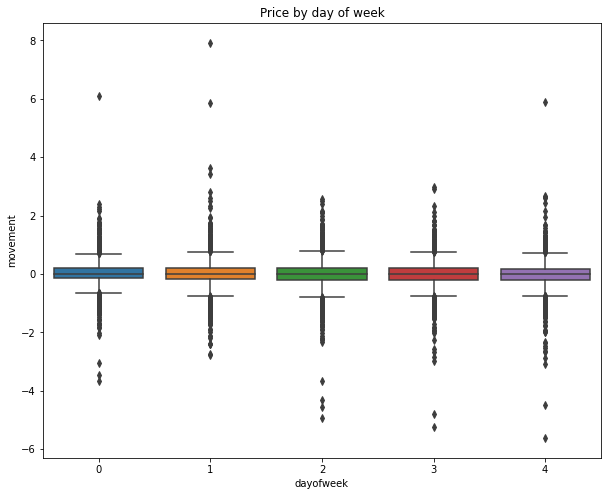

In [24]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='dayofweek', y='movement')
ax.set_title('Price by day of week')
plt.show()

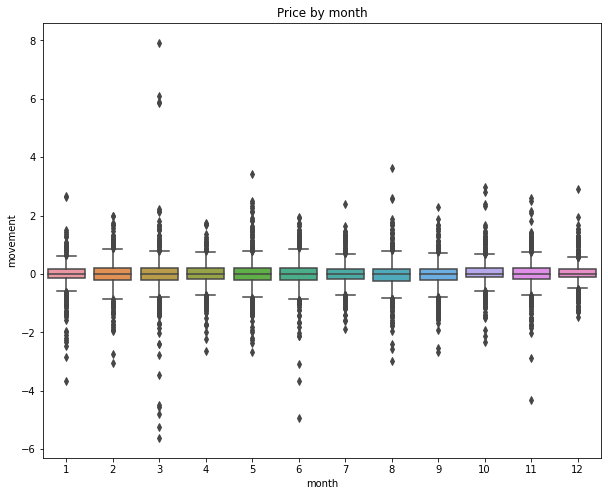

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='month', y='movement')
ax.set_title('Price by month')
plt.show()

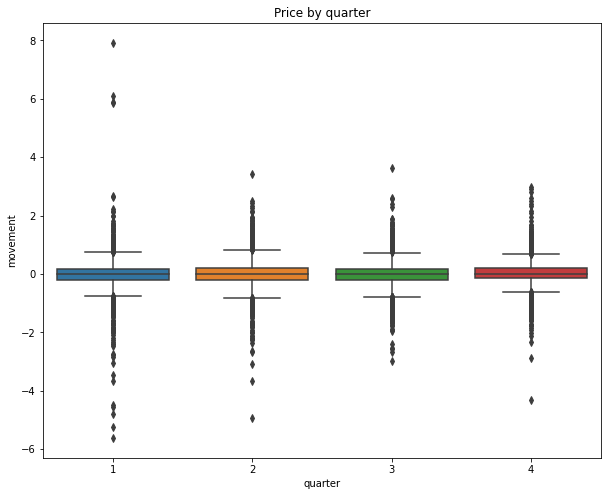

In [26]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='quarter', y='movement')
ax.set_title('Price by quarter')
plt.show()

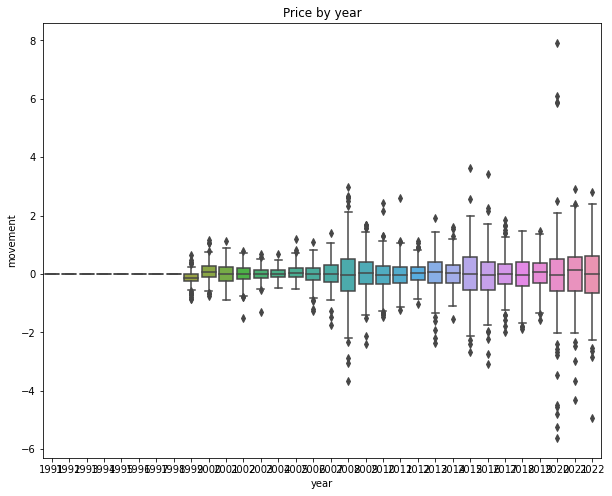

In [27]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df2, x='year', y='movement')
ax.set_title('Price by year')
plt.show()

In [28]:
cba

,movement
date,
1991-10-01,0.000000
1991-10-02,0.000000
1991-10-03,0.000000
1991-10-04,0.000000
1991-10-07,0.000000
...,...
2022-09-29,-0.709999
2022-09-30,-2.520004
2022-10-03,-0.540001


In [34]:
train = cba[:'2021'].iloc[:,1].values
test = cba['2022':].iloc[:,1].values

IndexError: single positional indexer is out-of-bounds

In [33]:
train.shape

(7670,)